In [2]:
from pathlib import Path
from PIL import Image
import itertools
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms
import torch.nn as nn
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np

In [3]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataload = DataLoader(datasets.MNIST("./", train=True, download=True, transform=transform),
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last=True)

In [4]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.channels,self.img_rows,self.img_cols)
        self.latent_dim = 128
        
        net = []
        
        for i in range(1,4):
            
            net.append(nn.Linear(self.latent_dim*2**(i-1), self.latent_dim*2**i))
            net.append(nn.LeakyReLU(0.2, inplace=True))
            net.append(nn.BatchNorm1d(self.latent_dim*2**i,0.8))
            
        net.append(nn.Linear(1024, np.prod(self.img_shape)))
        net.append(nn.Tanh())
        
        self.model = nn.Sequential(*net)


    def forward(self, noise):
        img = self.model(noise)
        return img.view(img.size(0), *self.img_shape)

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.channels,self.img_rows,self.img_cols)
        
        self.model = nn.Sequential(
            nn.Linear(np.prod(self.img_shape), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(img.size(0), -1)
        return self.model(img)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

In [7]:
optimizer_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [8]:
loss = torch.nn.BCELoss().to(device)

In [9]:
def img_samples(G,epoch):
    
    unloader = transforms.ToPILImage()
    noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 128))).cuda()
    plt.figure(figsize=(10,10))
    new_imgs = G(noise).cpu()
    
    for i in range(36):
        plt.subplot(6,6,i+1)
        img = unloader(new_imgs.data[i])
        plt.imshow(img, cmap='gist_gray')
        plt.axis('off')
        
    plt.savefig("/images/img_%i.png"%epoch)
    plt.close()

In [10]:
epoches = 100
k = 1

In [11]:
for epoch in tqdm(range(epoches), desc="Epoch"):
    
    g_loss_run = []
    d_loss_run = []
    
    for batch,i in dataload:
        
        real = batch.to(device)
        noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 128))).to(device)
        gen = G(noise)

        valid = torch.autograd.Variable(torch.Tensor(real.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = torch.autograd.Variable(torch.Tensor(real.size(0), 1).fill_(0.0), requires_grad=False).to(device)

        """
            Train Discriminator
        """
        
        for _ in range(k):
            
            D.train()
            optimizer_D.zero_grad()
            
            d_loss = loss(D(real), valid) + loss(D(gen.detach()), fake)
            
            d_loss.backward()
            optimizer_D.step()
            d_loss_run.append(d_loss.item())
            
        """
            Train Generator
        """
        
        G.train()
        optimizer_G.zero_grad()
        
        g_loss = loss(D(gen),valid)
        #print(g_loss.item(), d_loss.item())
            
        g_loss.backward()
        optimizer_G.step()
        g_loss_run.append(g_loss.item())
    
    img_samples(G,epoch)
    
    if epoch % 10 == 0:
        print("D loss: {0}\t||\tG loss: {1}".format(np.mean(d_loss_run),np.mean(g_loss_run)))
        torch.save(G, f'/saved_model/G_{epoch}.pth')
        torch.save(D, f'/saved_model/D_{epoch}.pth')

KeyboardInterrupt: 

In [32]:
torch.save(G, f'/saved_model/G_{100}.pth')
torch.save(D, f'/saved_model/D_{100}.pth')

In [23]:
path = '/Users/haru4me/Documents/Проекты/GAN/proj/images/'

import imageio
images = []
for i in range(100):
    images.append(imageio.imread(path+"img_%i.png"%i))
imageio.mimsave(path+'MNIST_gen.gif', images)

In [47]:
path = '/Users/haru4me/Documents/Проекты/GAN/proj/saved_model/G_ab_100.pth'
G = torch.load(path,map_location=torch.device('cpu'))
G.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

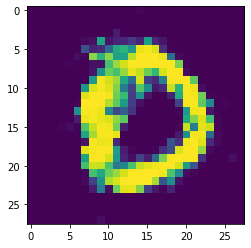

In [49]:
noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 128))).to(device)
unloader = transforms.ToPILImage()

plt.imshow(unloader(G(noise).cpu()[0]))

In [62]:
test = True

if test == False:
    dirr = "train_imgs"
else:
    dirr = "test_imgs"